In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from shapely import wkt
import h3
import contextily as ctx

In [2]:
sample = pd.read_parquet("df_trips_sample.parquet")
sample = sample.drop(columns = ["Pickup Centroid Latitude","Pickup Centroid Longitude","Dropoff Centroid Latitude","Dropoff Centroid Longitude"])
sample["Trip Start Timestamp"] = pd.to_datetime(sample["Trip Start Timestamp"])
sample["Trip End Timestamp"] = pd.to_datetime(sample["Trip End Timestamp"])
sample["Pickup Census Tract"] = sample["Pickup Census Tract"].round().astype("str").replace("nan",np.nan)
sample["Dropoff Census Tract"] = sample["Dropoff Census Tract"].round().astype("str").replace("nan",np.nan)
sample.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Location,Dropoff Centroid Location
24357273,06bd2062d4da87baf5e6c60645adf4018ff5a1f5,3c0dce2f97f9acc211c5a886cff53caf700e8ba821ae26...,2017-12-18 11:15:00,2017-12-18 12:00:00,3000.0,11.20,NaN,NaN,60.0,3.0,37.50,0.0,0.0,0.0,37.50,Cash,Chicago Independents,POINT (-87.6487879519 41.8361501547),POINT (-87.6558787862 41.96581197)
23594347,636eae5de0817802f3befa320b660551e245f0af,dcfc039460c91afe6099789b8f3b8ef854815c6345723e...,2017-12-06 20:15:00,2017-12-06 20:30:00,420.0,1.10,17031839100.0,17031081600.0,32.0,8.0,6.75,2.0,0.0,0.0,8.75,Credit Card,Taxi Affiliation Services,POINT (-87.6327464887 41.8809944707),POINT (-87.6288741572 41.8920726347)
14171117,a7c5166b39b3eb990f6aa84e43b5064f43c3cc79,ca85563c7c46f07258ff388e8a43a1502115d1824dd00b...,2017-07-17 23:30:00,2017-07-17 23:45:00,900.0,5.66,NaN,NaN,NaN,NaN,17.25,0.0,0.0,1.0,18.25,Cash,Taxi Affiliation Service Yellow,None,None
13794016,25c415d2f38913f8a5c789e7a7002a12e1a13e75,f2701208e420d05c34de4131a15848a786b13422bf5865...,2017-07-12 17:15:00,2017-07-12 18:15:00,3420.0,21.00,17031841000.0,17031980000.0,33.0,76.0,51.50,0.0,0.0,1.5,53.00,Cash,Top Cab Affiliation,POINT (-87.6241352979 41.84924675450001),POINT (-87.9030396611 41.9790708201)
12304106,0a67be58ffe7778950205e6dc105e4a57ba58192,c81a672f30763423ddc7abac2b2e20a2f1ea045088ef77...,2017-06-20 10:45:00,2017-06-20 10:45:00,19.0,0.00,17031081500.0,17031081500.0,8.0,8.0,3.25,0.0,NaN,0.0,3.25,Cash,Checker Taxi,POINT (-87.6262149064 41.8925077809),POINT (-87.6262149064 41.8925077809)


## Bauen: Filter für min Seconds

In [3]:
sample_filtered = sample.nsmallest(int(sample.index.size * 0.999), "Trip Total", keep='first')
total_filter = sample_filtered["Trip Total"].max()
print("Max Total:",total_filter)

sample_filtered = sample.nsmallest(int(sample.index.size * 0.999), "Trip Seconds", keep='first')
seconds_filter = sample_filtered["Trip Seconds"].max()
print("Max Seconds:",seconds_filter)

df = sample.copy()[(sample["Trip Total"] <= total_filter)&
                   (sample["Trip Seconds"]<=seconds_filter)&
                   (sample["Trip Seconds"]> 0)]
print("Kept",np.round(df.index.size / sample.index.size,4),"percent of data")

Max Total: 124.5
Max Seconds: 6900.0
Kept 0.9774 percent of data


(array([2.442157e+06, 1.570000e+02, 2.900000e+01, 1.600000e+01,
        1.400000e+01, 6.000000e+00, 1.400000e+01, 1.000000e+00,
        2.000000e+00, 1.000000e+00]),
 array([0.        , 0.00080889, 0.00161778, 0.00242667, 0.00323556,
        0.00404444, 0.00485333, 0.00566222, 0.00647111, 0.00728   ,
        0.00808889]),
 <BarContainer object of 10 artists>)

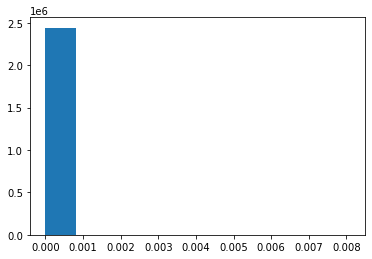

In [6]:
df["mph"] = df["Trip Miles"] / (df["Trip Seconds"] *3600)
plt.hist(df["mph"])

In [7]:
print("0$ Total Trips:",df[df["Trip Total"]==0].index.size)
print("0$ Fare Trips:",df[df["Trip Total"]==0].index.size)

0$ Total Trips: 282
0$ Fare Trips: 282


In [103]:
df[["Trip Total","Tolls","Tips","Extras","Fare"]].sample(10)

,Trip Total,Tolls,Tips,Extras,Fare
1587239,24.30,0.0,4.05,0.0,19.75
18692821,5.00,0.0,0.00,0.0,5.00
13475498,6.25,0.0,0.00,1.0,5.25
726167,7.00,0.0,1.00,0.0,5.50
13746410,18.00,0.0,1.00,4.0,13.00
5917634,9.00,NaN,0.00,0.0,9.00
18140872,10.75,0.0,0.00,0.0,10.75
19271452,13.75,0.0,0.00,2.0,11.75
2891275,6.25,0.0,0.00,0.0,6.25
20626467,7.00,0.0,0.00,0.0,7.00


In [ ]:
df["weekday"] = df["Trip Start Timestamp"].dt.weekday < 5

AttributeError: 'AxesSubplot' object has no attribute 'colorbar'

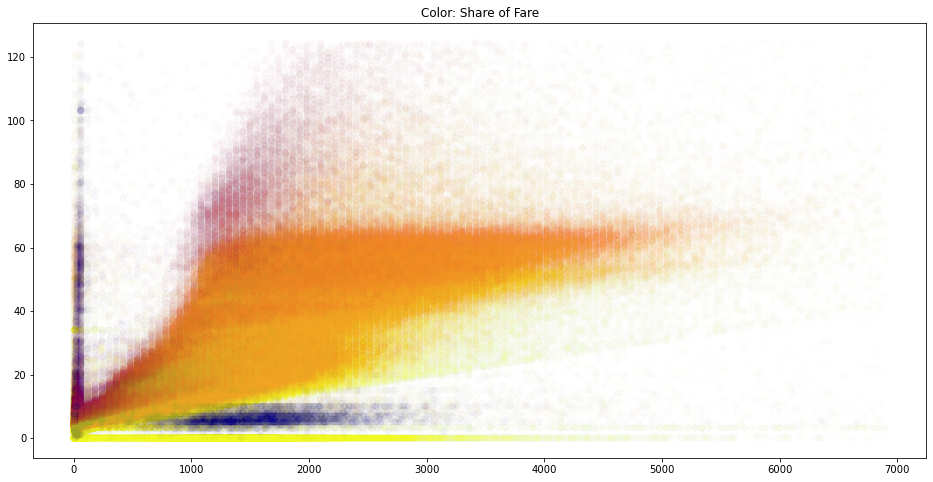

In [9]:
df["fare_share"] = df["Fare"] / df["Trip Total"]
df["tips_share"] = df["Tips"] / df["Trip Total"]
df["tolls_share"] = df["Tolls"] / df["Trip Total"]
df["extras_share"] = df["Extras"] / df["Trip Total"]

fig,ax=plt.subplots(1,1,figsize=(16,8))
#fig.suptitle("Trip Length (s) in comparison to Trip Total ($))")
seconds_total_plot = ax.scatter(x=df["Trip Seconds"],y=df["Trip Total"],alpha=0.01,c=df["fare_share"],cmap="plasma")
ax.set_title("Color: Share of Fare")
#ax.colorbar(seconds_total_plot)


#ax[1,0].scatter(x=df["Trip Seconds"],y=df["Trip Total"],alpha=0.01,c=df["tips_share"],cmap="plasma")
#ax[1,0].set_title("Color: Share of Tips")
#ax[0,1].scatter(x=df["Trip Seconds"],y=df["Trip Total"],alpha=0.01,c=df["tolls_share"],cmap="plasma")
#ax[0,1].set_title("Color: Share of Tolls")
#ax[1,1].scatter(x=df["Trip Seconds"],y=df["Trip Total"],alpha=0.01,c=df["extras_share"],cmap="plasma")
#ax[1,1].set_title("Color: Share of Extras")

In [15]:
df["Dropoff Centroid  Location"]

24357273      POINT (-87.6558787862 41.96581197)
23594347    POINT (-87.6288741572 41.8920726347)
14171117                                    None
13794016    POINT (-87.9030396611 41.9790708201)
12304106    POINT (-87.6262149064 41.8925077809)
                            ...                 
1757034      POINT (-87.6333080367 41.899602111)
18461321    POINT (-87.6559981815 41.9442266014)
12920381    POINT (-87.6327464887 41.8809944707)
21412315    POINT (-87.6327464887 41.8809944707)
3654532     POINT (-87.6572331997 41.8852813201)
Name: Dropoff Centroid  Location, Length: 2442398, dtype: object

In [16]:
#Converting String Points to GDF

def load_wkt(value):
    if isinstance(value,str):
        return wkt.loads(value)
    else:
        return np.nan


df['PU_Centroid'] = df["Pickup Centroid Location"].apply(load_wkt)
df["DO_Centroid"] =  df["Dropoff Centroid  Location"].apply(load_wkt)

# Geopandas GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='PU_Centroid')
gdf.drop(columns=["Pickup Centroid Location","Dropoff Centroid  Location"])

gdf.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Company,Pickup Centroid Location,Dropoff Centroid Location,mph,fare_share,tips_share,tolls_share,extras_share,PU_Centroid,DO_Centroid
24357273,06bd2062d4da87baf5e6c60645adf4018ff5a1f5,3c0dce2f97f9acc211c5a886cff53caf700e8ba821ae26...,2017-12-18 11:15:00,2017-12-18 12:00:00,3000.0,11.20,NaN,NaN,60.0,3.0,...,Chicago Independents,POINT (-87.6487879519 41.8361501547),POINT (-87.6558787862 41.96581197),1.037037e-06,1.000000,0.000000,0.0,0.000000,POINT (-87.64879 41.83615),POINT (-87.65587878620001 41.96581197)
23594347,636eae5de0817802f3befa320b660551e245f0af,dcfc039460c91afe6099789b8f3b8ef854815c6345723e...,2017-12-06 20:15:00,2017-12-06 20:30:00,420.0,1.10,17031839100.0,17031081600.0,32.0,8.0,...,Taxi Affiliation Services,POINT (-87.6327464887 41.8809944707),POINT (-87.6288741572 41.8920726347),7.275132e-07,0.771429,0.228571,0.0,0.000000,POINT (-87.63275 41.88099),POINT (-87.6288741572 41.8920726347)
14171117,a7c5166b39b3eb990f6aa84e43b5064f43c3cc79,ca85563c7c46f07258ff388e8a43a1502115d1824dd00b...,2017-07-17 23:30:00,2017-07-17 23:45:00,900.0,5.66,NaN,NaN,NaN,NaN,...,Taxi Affiliation Service Yellow,None,None,1.746914e-06,0.945205,0.000000,0.0,0.054795,None,NaN
13794016,25c415d2f38913f8a5c789e7a7002a12e1a13e75,f2701208e420d05c34de4131a15848a786b13422bf5865...,2017-07-12 17:15:00,2017-07-12 18:15:00,3420.0,21.00,17031841000.0,17031980000.0,33.0,76.0,...,Top Cab Affiliation,POINT (-87.6241352979 41.84924675450001),POINT (-87.9030396611 41.9790708201),1.705653e-06,0.971698,0.000000,0.0,0.028302,POINT (-87.62414 41.84925),POINT (-87.9030396611 41.9790708201)
12304106,0a67be58ffe7778950205e6dc105e4a57ba58192,c81a672f30763423ddc7abac2b2e20a2f1ea045088ef77...,2017-06-20 10:45:00,2017-06-20 10:45:00,19.0,0.00,17031081500.0,17031081500.0,8.0,8.0,...,Checker Taxi,POINT (-87.6262149064 41.8925077809),POINT (-87.6262149064 41.8925077809),0.000000e+00,1.000000,0.000000,NaN,0.000000,POINT (-87.62621 41.89251),POINT (-87.62621490639999 41.8925077809)


In [109]:
gdf_pu_grouped

count               h3  \
PU_hour PU_H3                                     
0       8826641915fffff      3  8826641915fffff   
        8826641961fffff     16  8826641961fffff   
        8826641b23fffff      6  8826641b23fffff   
        882664520bfffff   1864  882664520bfffff   
        8826645215fffff     39  8826645215fffff   
...                        ...              ...   
3       88275934edfffff  42820  88275934edfffff   
        8827593699fffff    397  8827593699fffff   
        88275936b1fffff      9  88275936b1fffff   
        88275936bbfffff      1  88275936bbfffff   
        88275936d5fffff     27  88275936d5fffff   

                                                                  geometry  
PU_hour PU_H3                                                               
0       8826641915fffff  POLYGON ((-87.54296 41.66657, -87.54898 41.664...  
        8826641961fffff  POLYGON ((-87.57319 41.69756, -87.57921 41.695...  
        8826641b23fffff  POLYGON ((-87.53039 41.71477, -87.53641 41.712...  
        882664520bfffff  POLYGON ((-87.76679 41.79984, -87.77281 41.798...  
        8826645215fffff  POLYGON ((-87.76869 41.78590, -87.77471 41.784...  
...                                                                    ...  
3       88275934edfffff  POLYGON ((-87.90424 41.98162, -87.91028 41.979...  
        8827593699fffff  POLYGON ((-87.80404 41.99392, -87.81009 41.992...  
        88275936b1fffff  POLYGON ((-87.84030 41.98301, -87.84635 41.981...  
        88275936bbfffff  POLYGON ((-87.82885 41.98199, -87.83489 41.980...  
        88275936d5fffff  POLYGON ((-87.81361 42.00892, -87.81965 42.007...  

[942 rows x 3 columns]

In [110]:
#Converting Geo-Points to H3

def h3_conversion(value,h3_level):
    if isinstance(value,shapely.geometry.point.Point):
        return h3.geo_to_h3(value.y, value.x, h3_level)
    else:
        return np.nan

gdf["PU_H3"] = gdf.apply(lambda x: h3_conversion(x["PU_Centroid"],7),axis=1)
gdf["DO_H3"] = gdf.apply(lambda x: h3_conversion(x["DO_Centroid"],7),axis=1)

def hex_to_geoboundary(value):
    if isinstance(value,str):
        return shapely.geometry.Polygon(h3.h3_to_geo_boundary(value, True))
    else:
        return np.nan

gdf_pu_grouped = gdf.copy()
gdf_pu_grouped["PU_hour"] = np.floor(gdf_pu_grouped["Trip Start Timestamp"].dt.hour / 6).astype(int)
gdf_pu_grouped = gdf_pu_grouped.groupby(["PU_hour","PU_H3"]).agg(count=("PU_H3","count"))
gdf_pu_grouped["h3"] = gdf_pu_grouped.index.get_level_values(1)
gdf_pu_grouped["geometry"] = gdf_pu_grouped.apply(lambda x: hex_to_geoboundary(x["h3"]),axis=1)
gdf_pu_grouped = gpd.GeoDataFrame(gdf_pu_grouped, geometry='geometry')

gdf_do_grouped = gdf.copy()
gdf_do_grouped["DO_hour"] = np.floor(gdf_do_grouped["Trip End Timestamp"].dt.hour / 6).astype(int)
gdf_do_grouped = gdf_do_grouped.groupby(["DO_hour","DO_H3"]).agg(count=("DO_H3","count"))
gdf_do_grouped["h3"] = gdf_do_grouped.index.get_level_values(1)
gdf_do_grouped["geometry"] = gdf_do_grouped.apply(lambda x: hex_to_geoboundary(x["h3"]),axis=1)
gdf_do_grouped = gpd.GeoDataFrame(gdf_do_grouped, geometry='geometry')

<AxesSubplot:>

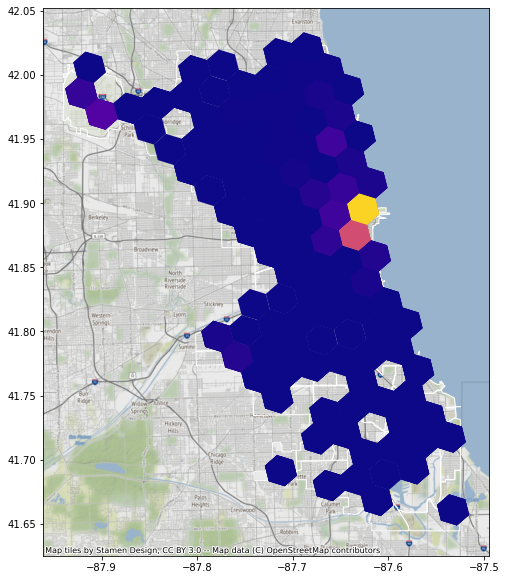

In [111]:
fig,ax = plt.subplots(figsize = (8,12))

chicago_fence = gpd.read_file("chicago-community-areas.geojson")
chicago_fence.plot(ax=ax,edgecolor="white",color="none")
gdf_pu_grouped.plot(ax=ax,cmap="plasma",column="count")
ctx.add_basemap(ax,zoom=12,crs=4326)
chicago_fence.plot(ax=ax,alpha=0)